In [16]:
%matplotlib inline
import GEOparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
import statsmodels.api as sm
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklego.linear_model import LowessRegression

### Reading in from external source

In [17]:
geo = "GSE94536"
data = GEOparse.get_GEO(geo=geo, destdir="../Dataset/Li2017", silent=True)
#table = pd.read_csv("../Dataset/Fehlman2020/expression_matrix.csv", sep="\t")
#table = pd.read_csv("../Dataset/Wozniak2015/GSE64591_non-normalized.txt", sep="\t", header=5)

In [18]:
table = pd.concat((val.table.iloc[:,1:] for val in data.gsms.values()), axis=1).transpose()
mirnas = list(data.gsms.values())[0].table.iloc[:,0]

In [19]:
table

,0,1,2,3,4,5,6,7,8,9,...,2539,2540,2541,2542,2543,2544,2545,2546,2547,2548
VALUE,0.10000,0.10000,0.1,0.1,0.1,0.10000,0.10000,0.1000,0.1,0.10000,...,0.1,0.1,0.1,3.78867,0.1,0.10000,0.1,0.1,0.1,0.10000
VALUE,0.10000,2.84215,0.1,0.1,0.1,0.10000,0.10000,0.1000,0.1,0.10000,...,0.1,0.1,0.1,9.53514,0.1,0.10000,0.1,0.1,0.1,0.10000
VALUE,0.10000,4.16109,0.1,0.1,0.1,0.10000,0.10000,0.1000,0.1,0.10000,...,0.1,0.1,0.1,5.93378,0.1,0.10000,0.1,0.1,0.1,0.10000
VALUE,0.10000,0.10000,0.1,0.1,0.1,0.10000,0.10000,0.1000,0.1,0.10000,...,0.1,0.1,0.1,0.10000,0.1,0.10000,0.1,0.1,0.1,0.10000
VALUE,1.55445,0.10000,0.1,0.1,0.1,0.10000,0.10000,0.1000,0.1,0.10000,...,0.1,0.1,0.1,2.10564,0.1,0.10000,0.1,0.1,0.1,0.10000
VALUE,0.10000,0.10000,0.1,0.1,0.1,0.10000,0.10000,0.1000,0.1,0.10000,...,0.1,0.1,0.1,0.10000,0.1,0.10000,0.1,0.1,0.1,0.10000
VALUE,0.10000,283.80890,0.1,0.1,0.1,63.38276,10.58558,124.8117,0.1,15.65303,...,0.1,0.1,0.1,344.32600,0.1,6.70158,0.1,0.1,0.1,2.75548
VALUE,0.10000,249.27970,0.1,0.1,0.1,68.02007,9.89041,107.1587,0.1,2.45958,...,0.1,0.1,0.1,394.66400,0.1,4.75734,0.1,0.1,0.1,0.10000
VALUE,0.10000,0.10000,0.1,0.1,0.1,0.10000,3.77247,0.1000,0.1,0.10000,...,0.1,0.1,0.1,3.71492,0.1,0.10000,0.1,0.1,0.1,0.10000


### Seperate case and controls

In [20]:
stages = [m.metadata["characteristics_ch1"][5].split(" ")[2] for m in data.gsms.values()]
stages = [m.count("I") + 3*m.count("V") for m in stages]
stages

[4, 4, 3, 4, 4, 4, 0, 0, 0]

In [21]:
set([k.metadata["characteristics_ch1"][0] for k in list(data.gsms.values())])

{'plasma: healthy donor', 'plasma: primary lung cancer'}

In [22]:
sick = np.array(["cancer" in k.metadata["characteristics_ch1"][0] for k in list(data.gsms.values())])
controls = 1 - sick

In [23]:
sum(controls)

3

### Drop NAN

In [24]:
mask = table.std() != 0
table = table.loc[:, mask]
mirnas = mirnas[mask]

In [25]:
table = table.dropna(1)

C:\Users\olefr\AppData\Local\Temp/ipykernel_33472/1927661217.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  table = table.dropna(1)


### T-test

In [26]:
X = table

In [27]:
X

,0,1,5,6,7,9,12,14,16,19,...,2516,2519,2523,2526,2529,2531,2532,2542,2544,2548
VALUE,0.10000,0.10000,0.10000,0.10000,0.1000,0.10000,0.10000,0.10000,2.81054,0.10000,...,119.19110,0.10000,5.03178,0.10000,1.84522,9.35345,0.10000,3.78867,0.10000,0.10000
VALUE,0.10000,2.84215,0.10000,0.10000,0.1000,0.10000,3.48693,2.85913,8.86201,0.10000,...,74.26930,0.10000,8.81913,0.10000,3.32140,4.58324,0.10000,9.53514,0.10000,0.10000
VALUE,0.10000,4.16109,0.10000,0.10000,0.1000,0.10000,4.04358,2.80796,7.24243,0.10000,...,38.17760,0.10000,3.63730,0.10000,0.10000,7.84305,0.10000,5.93378,0.10000,0.10000
VALUE,0.10000,0.10000,0.10000,0.10000,0.1000,0.10000,0.10000,0.10000,0.10000,0.10000,...,20.03903,0.10000,2.25616,0.10000,0.10000,3.04235,1.56216,0.10000,0.10000,0.10000
VALUE,1.55445,0.10000,0.10000,0.10000,0.1000,0.10000,0.10000,0.10000,0.10000,0.10000,...,24.17352,1.25686,0.10000,3.59980,8.85093,11.77476,0.10000,2.10564,0.10000,0.10000
VALUE,0.10000,0.10000,0.10000,0.10000,0.1000,0.10000,0.10000,0.10000,0.10000,0.10000,...,6.70371,0.10000,0.10000,0.10000,0.10000,5.57755,0.10000,0.10000,0.10000,0.10000
VALUE,0.10000,283.80890,63.38276,10.58558,124.8117,15.65303,188.35280,114.28900,222.61160,3.33573,...,368.86600,0.10000,82.53000,6.89714,15.07545,7.70800,0.10000,344.32600,6.70158,2.75548
VALUE,0.10000,249.27970,68.02007,9.89041,107.1587,2.45958,144.14910,100.13010,235.91000,2.64779,...,470.08000,0.10000,103.08610,8.66296,23.73170,11.11048,0.10000,394.66400,4.75734,0.10000
VALUE,0.10000,0.10000,0.10000,3.77247,0.1000,0.10000,1.66250,0.10000,0.10000,0.10000,...,85.64210,0.10000,2.14897,4.22067,6.49181,14.77457,0.10000,3.71492,0.10000,0.10000


In [28]:
X_healthy, X_cancer = X[controls == 1], X[sick == 1]

In [29]:
results = ttest_ind(X_healthy, X_cancer).pvalue

In [30]:
lowest, pvalues = np.argsort(results)[:5], np.sort(results)[:5]

In [31]:
mirnas.iloc[lowest], pvalues

(1220    A_25_P00016339
 1091    A_25_P00017131
 1440    A_25_P00010431
 126     A_25_P00015195
 1863    A_25_P00017983
 Name: ID_REF, dtype: object,
 array([2.20065395e-08, 1.63215772e-07, 1.36146586e-06, 2.99123328e-06,
        3.26820982e-06]))

### F-test

In [32]:
t3 = table

In [33]:
f, p = f_classif(t3, sick)

In [34]:
np.mean(p)

0.15056040848702015

### ANOVA

In [35]:
t3

,0,1,5,6,7,9,12,14,16,19,...,2516,2519,2523,2526,2529,2531,2532,2542,2544,2548
VALUE,0.10000,0.10000,0.10000,0.10000,0.1000,0.10000,0.10000,0.10000,2.81054,0.10000,...,119.19110,0.10000,5.03178,0.10000,1.84522,9.35345,0.10000,3.78867,0.10000,0.10000
VALUE,0.10000,2.84215,0.10000,0.10000,0.1000,0.10000,3.48693,2.85913,8.86201,0.10000,...,74.26930,0.10000,8.81913,0.10000,3.32140,4.58324,0.10000,9.53514,0.10000,0.10000
VALUE,0.10000,4.16109,0.10000,0.10000,0.1000,0.10000,4.04358,2.80796,7.24243,0.10000,...,38.17760,0.10000,3.63730,0.10000,0.10000,7.84305,0.10000,5.93378,0.10000,0.10000
VALUE,0.10000,0.10000,0.10000,0.10000,0.1000,0.10000,0.10000,0.10000,0.10000,0.10000,...,20.03903,0.10000,2.25616,0.10000,0.10000,3.04235,1.56216,0.10000,0.10000,0.10000
VALUE,1.55445,0.10000,0.10000,0.10000,0.1000,0.10000,0.10000,0.10000,0.10000,0.10000,...,24.17352,1.25686,0.10000,3.59980,8.85093,11.77476,0.10000,2.10564,0.10000,0.10000
VALUE,0.10000,0.10000,0.10000,0.10000,0.1000,0.10000,0.10000,0.10000,0.10000,0.10000,...,6.70371,0.10000,0.10000,0.10000,0.10000,5.57755,0.10000,0.10000,0.10000,0.10000
VALUE,0.10000,283.80890,63.38276,10.58558,124.8117,15.65303,188.35280,114.28900,222.61160,3.33573,...,368.86600,0.10000,82.53000,6.89714,15.07545,7.70800,0.10000,344.32600,6.70158,2.75548
VALUE,0.10000,249.27970,68.02007,9.89041,107.1587,2.45958,144.14910,100.13010,235.91000,2.64779,...,470.08000,0.10000,103.08610,8.66296,23.73170,11.11048,0.10000,394.66400,4.75734,0.10000
VALUE,0.10000,0.10000,0.10000,3.77247,0.1000,0.10000,1.66250,0.10000,0.10000,0.10000,...,85.64210,0.10000,2.14897,4.22067,6.49181,14.77457,0.10000,3.71492,0.10000,0.10000


In [36]:
X = np.array(sick).reshape(-1, 1)

In [37]:
linreg = LinearRegression()
linreg.fit(X, t3)

LinearRegression()

In [38]:
fitted = linreg.predict(X)
explained_variance_score(t3, fitted)

0.4753435358031404

### Mean-variance-plot

In [39]:
np.mean(table)

0        0.261606
1       60.065760
5       14.678092
6        2.760940
7       25.852267
          ...    
2531     8.418606
2532     0.262462
2542    84.918683
2544     1.350991
2548     0.395053
Length: 454, dtype: float64

In [40]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [41]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

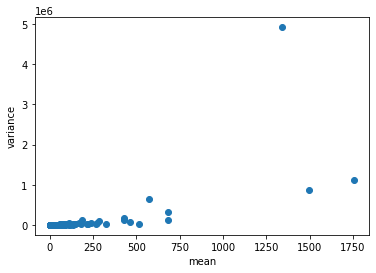

In [42]:
mean_variance_plot(table)

### Log transformation

In [43]:
log_table = np.log2(table)

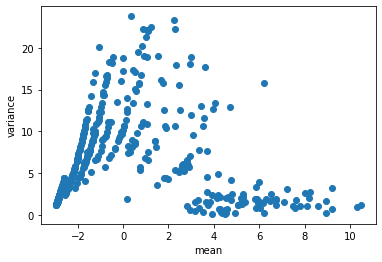

In [44]:
mean_variance_plot(log_table)

In [45]:
mask = log_table.mean() > 0
log_table = log_table.loc[:, mask]
mirnas = mirnas[mask]

### Loess regression

In [46]:
lowess = LowessRegression(sigma=1, span=0.1)

In [47]:
means, variances = get_means_and_variances(log_table)
lowess.fit(means.to_numpy().reshape(-1,1), variances)

LowessRegression(span=0.1)

In [48]:
x_axis = np.linspace(-2, 14, 100)
y_axis = lowess.predict(x_axis.reshape(-1,1))

[]

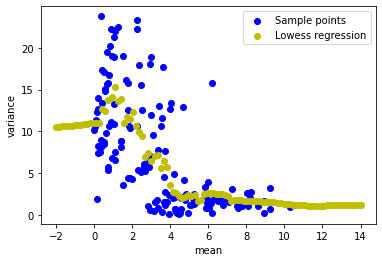

In [49]:
plt.scatter(means, variances, color="b")
plt.scatter(x_axis, y_axis, color="y")
plt.xlabel("mean")
plt.ylabel("variance")
plt.legend(["Sample points", "Lowess regression"])
plt.plot()

### Lowess normalization

In [50]:
adj_var = lowess.predict(means.to_numpy().reshape(-1, 1))

In [51]:
log_table /= np.sqrt(adj_var)

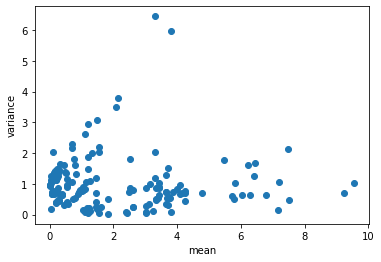

In [52]:
mean_variance_plot(log_table)

In [53]:
norm_log_table = log_table - np.mean(log_table)

In [54]:
norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))

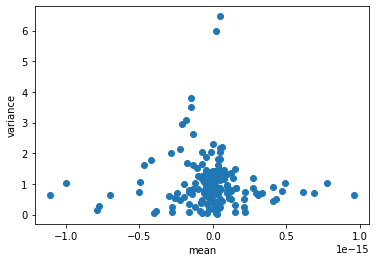

In [55]:
mean_variance_plot(norm_log_table)

### PCA

In [56]:
pca = decomposition.PCA(n_components=2)

In [57]:
pca.fit(norm_log_table)

PCA(n_components=2)

In [58]:
pca.explained_variance_ratio_

array([0.69312181, 0.10868886])

In [59]:
components = pca.transform(norm_log_table)

In [60]:
components.shape

(9, 2)

In [61]:
sum(controls)

3

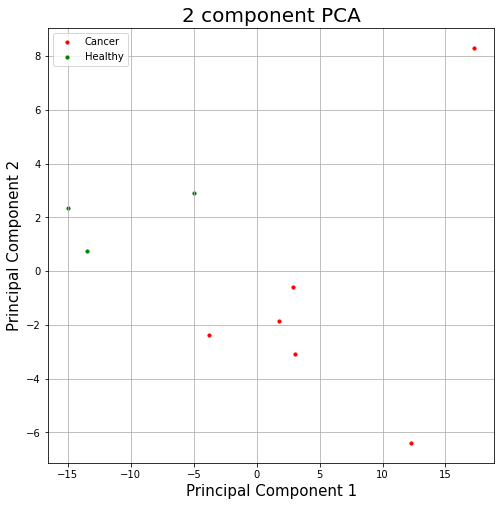

In [62]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

In [63]:
components2 = components[components[:,0] < 20, :]
controls2 = controls[components[:,0] < 20]

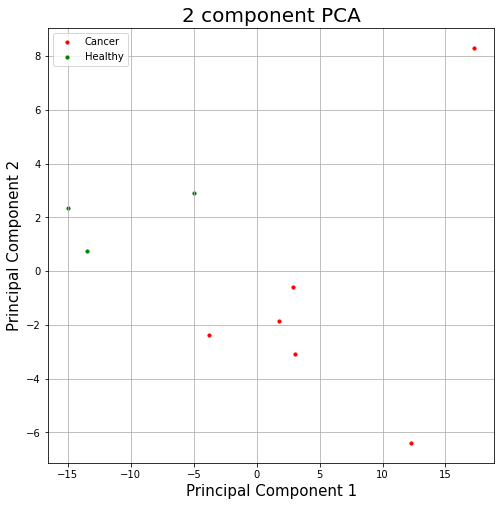

In [64]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components2[controls2 == False, 0], components2[controls2 == False, 1], c = 'r', s = 10)
ax.scatter(components2[controls2 == True, 0], components2[controls2 == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Linear regression adjustments

In [65]:
sex = np.array(["Female" in k.metadata["characteristics_ch1"][2] for k in list(data.gsms.values()) if "post" not in k.metadata["characteristics_ch1"][0]])
age = np.array([float(k.metadata["characteristics_ch1"][1].split(" ")[1].replace("NA", "NaN")) for k in list(data.gsms.values()) if "post" not in k.metadata["characteristics_ch1"][0]])

In [66]:
covars = pd.DataFrame(np.array([sex, age]).transpose(), columns=["sex", "age"])

In [67]:
covars = covars.fillna(covars.mean())

In [68]:
linreg = LinearRegression()
linreg.fit(covars, norm_log_table)

LinearRegression()

In [69]:
adj_norm_log_table = norm_log_table - linreg.predict(covars)

# PCA

In [70]:
pca = decomposition.PCA(n_components=2)

In [71]:
pca.fit(adj_norm_log_table)

PCA(n_components=2)

In [72]:
components = pca.transform(adj_norm_log_table)

In [73]:
components

array([[-4.47034421, -0.67178479],
       [-6.53982831, -3.37654991],
       [ 2.43693557, -4.26923347],
       [15.30141273, -4.69906418],
       [-5.53668165,  3.02184637],
       [14.70003503,  3.87382321],
       [-8.48589681, -0.86087186],
       [-8.16020672, -0.4972733 ],
       [ 0.75457437,  7.47910794]])

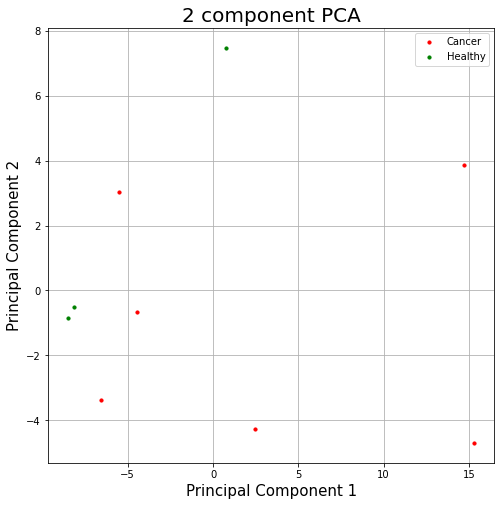

In [74]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Logistic Regression

In [75]:
X_train, X_test, y_train, y_test = train_test_split(adj_norm_log_table, controls, test_size=0.33, random_state=42)

In [76]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


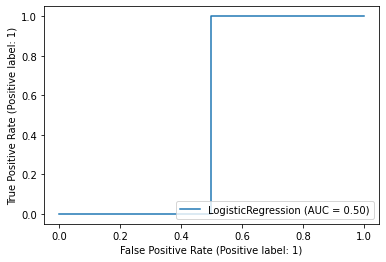

In [77]:
plot_roc_curve(model, X_test, y_test)

### XGBoost

In [78]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[00:26:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


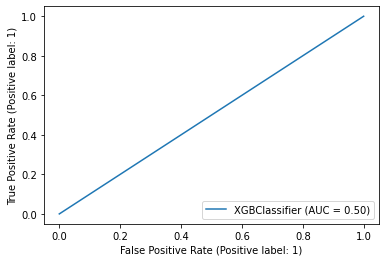

In [79]:
plot_roc_curve(model, X_test, y_test)

### Export data

In [80]:
lookup_table = data.gpls["GPL21576"].table

In [81]:
lookup_table = lookup_table.set_index("ID")
lookup_table.head()

,miRNA_ID,SPOT_ID,GENE_SYMBOL,GENE_NAME,ACCESSION_STRING,CHROMOSOMAL_LOCATION,SPOT_ID.1
ID,,,,,,,
(-)3xSLv1,NaN,--NegativeControl,NaN,NaN,NaN,NaN,NaN
A_25_P00010019,hsa-miR-329-3p,NaN,hsa-miR-329-3p,hsa-miR-329-3p,mir|hsa-miR-329-3p|mir|MIMAT0001629|mir|hsa-mi...,"chr14:101493173-101493192,chr14:101493490-1014...",NaN
A_25_P00010020,hsa-miR-329-3p,NaN,hsa-miR-329-3p,hsa-miR-329-3p,mir|hsa-miR-329-3p|mir|MIMAT0001629|mir|hsa-mi...,"chr14:101493174-101493192,chr14:101493491-1014...",NaN
A_25_P00010021,hsa-miR-655-3p,NaN,hsa-miR-655-3p,hsa-miR-655-3p,mir|hsa-miR-655-3p|mir|MIMAT0003331|mir|hsa-mi...,chr14:101515949-101515968,NaN
A_25_P00010023,hsa-miR-369-3p,NaN,hsa-miR-369-3p,hsa-miR-369-3p,mir|hsa-miR-369-3p|mir|MIMAT0000721,unmapped,NaN


In [82]:
access_ids = lookup_table.loc[mirnas]["ACCESSION_STRING"]

In [83]:
access_ids = [a.split("|")[-1] for a in access_ids]

In [84]:
access_ids[:10]

['MIMAT0000062',
 'MIMAT0000067',
 'MIMAT0000415',
 'MIMAT0000101',
 'MIMAT0000680',
 'MIMAT0000104',
 'MIMAT0005865',
 'MIMAT0005871',
 'MIMAT0000421',
 'MIMAT0005577']

In [85]:
from Scripts import converters

In [86]:
sequences = converters.mirbase_to_seq(access_ids)

In [87]:
sequences[:10]

['UGAGGUAGUAGGUUGUAUAGUU',
 'UGAGGUAGUAGAUUGUAUAGUU',
 'UGAGGUAGUAGUUUGUGCUGUU',
 'AGCAGCAUUGUACAGGGCUAUGA',
 'UAAAGUGCUGACAGUGCAGAU',
 'AGCAGCAUUGUACAGGGCUAUCA',
 'GUGCCAGCUGCAGUGGGGGAG',
 'UGGCAGGGAGGCUGGGAGGGG',
 'UGGAGUGUGACAAUGGUGUUUG',
 'UCACCAGCCCUGUGUUCCCUAG']

In [88]:
adj_norm_log_table.columns = sequences
adj_norm_log_table["cancer"] = sick
adj_norm_log_table["stage"] = stages
adj_norm_log_table.head()

,UGAGGUAGUAGGUUGUAUAGUU,UGAGGUAGUAGAUUGUAUAGUU,UGAGGUAGUAGUUUGUGCUGUU,AGCAGCAUUGUACAGGGCUAUGA,UAAAGUGCUGACAGUGCAGAU,AGCAGCAUUGUACAGGGCUAUCA,GUGCCAGCUGCAGUGGGGGAG,UGGCAGGGAGGCUGGGAGGGG,UGGAGUGUGACAAUGGUGUUUG,UCACCAGCCCUGUGUUCCCUAG,...,UGCCCUGAGACUUUUGCUC,UCUGGUGUAUAGCGUUGCUCA,AUGUGAUUGACGGCUGACUCCA,UAUUGCACUCGUCCCGGCCUCC,ACAGUAGAGGGAGGAAUCGCAG,AUAAAGCUAGAUAACCGAAAGU,CACCCGGCUGUGUGCACAUGUGC,UGAGGUAGUAAGUUGUAUUGUU,cancer,stage
VALUE,0.042200,-0.016740,0.806834,0.033032,1.195829,1.014877,0.152274,0.153768,0.084189,-1.541224,...,0.193162,0.260718,0.111768,1.262803,0.992259,0.270582,0.092062,0.592139,True,4
VALUE,0.309654,0.463545,0.429356,0.663078,0.681036,0.673157,0.110803,0.230060,0.175595,1.378740,...,-0.236493,-0.213907,0.570886,0.551587,0.710252,0.314219,-0.188441,0.479214,True,4
VALUE,0.799427,0.579477,0.668416,0.354364,-0.890030,0.394493,-0.408766,-0.419076,-0.325813,0.558697,...,-0.061834,-0.059797,-0.879050,-0.423501,0.127539,-1.062701,-0.022000,0.188402,True,3
VALUE,-1.287335,-1.396935,-1.225432,-1.296744,-1.237624,-1.609156,-0.806339,-1.094848,-0.680851,0.255365,...,-1.012647,-0.954653,-1.532488,-1.425131,-0.541002,-1.189903,-0.553806,-2.077961,True,4
VALUE,0.337652,0.289970,-0.248767,0.328538,-0.145186,-0.292998,0.392547,0.630524,0.352872,0.675327,...,1.008669,0.789646,1.165291,0.078949,-0.454405,0.952863,0.224935,0.543814,True,4


In [89]:
adj_norm_log_table.to_csv("../TransformedData/Li2017_staged.csv", index=False)